In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import skimage
from skimage import io
#from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.color import *
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import plot_model
#import segmentation_models as sm

In [3]:
#memanggil data yang telah disimpan dalam numpy array
all_images = np.load('D:/TugasAkhir/DataSet/NPY File/all_data_images_overlap_0.5.npz')['arr_0']
all_labels = np.load('D:/TugasAkhir/DataSet/NPY File/all_data_labels_overlap_0.5.npz')['arr_0']
all_masks = np.load('D:/TugasAkhir/DataSet/NPY File/all_data_masks_overlap_0.5.npz')['arr_0']

In [4]:
print(all_images.shape)
print(all_masks.shape)
print(all_labels.shape)

(5839, 256, 256, 3)
(5839, 256, 256, 4)
(5839, 256, 256, 1)


### Ubah ke Categorical

In [5]:
all_cats = to_categorical(all_labels, num_classes=5)

In [6]:
all_cats.shape

(5839, 256, 256, 5)

Class yang ada dalam Cell:  [0. 1. 2.]


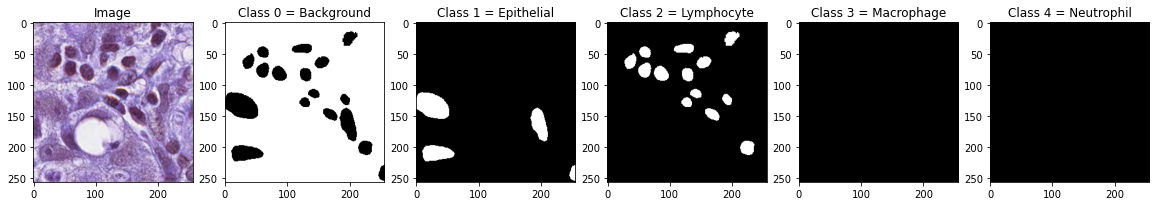

In [7]:
cek_ind=0
plt.figure(figsize=(20,4))
plt.subplot(1,6,1)
plt.imshow(all_images[cek_ind]);
plt.title('Image')
plt.subplot(1,6,2)
plt.imshow(all_cats[cek_ind][:,:,0], cmap='gray');
plt.title('Class 0 = Background')
plt.subplot(1,6,3)
plt.imshow(all_cats[cek_ind][:,:,1], cmap='gray');
plt.title('Class 1 = Epithelial')
plt.subplot(1,6,4)
plt.imshow(all_cats[cek_ind][:,:,2], cmap='gray');
plt.title('Class 2 = Lymphocyte')
plt.subplot(1,6,5)
plt.imshow(all_cats[cek_ind][:,:,3], cmap='gray');
plt.title('Class 3 = Macrophage')
plt.subplot(1,6,6)
plt.imshow(all_cats[cek_ind][:,:,4], cmap='gray');
plt.title('Class 4 = Neutrophil')

print("Class yang ada dalam Cell: ", np.unique(all_labels[cek_ind]))


### Prepare Training, Validation Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(all_images, all_cats, test_size=0.2, random_state=0)

In [9]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [10]:
print("Data latih: ", X_train.shape)
print("Data validasi: ", X_val.shape)
print("Data uji: ", X_test.shape)

print("Label data latih:", y_train.shape)
print("Label data validasi:", y_val.shape)
print("Label data uji:", y_test.shape)

Data latih:  (4671, 256, 256, 3)
Data validasi:  (584, 256, 256, 3)
Data uji:  (584, 256, 256, 3)
Label data latih: (4671, 256, 256, 5)
Label data validasi: (584, 256, 256, 5)
Label data uji: (584, 256, 256, 5)


### Function

In [11]:
def IoU_patch(y_test,predict):
    class0 = np.sum(np.logical_and(y_test[:,:,0],predict[:,:,0]))/(np.sum(np.logical_or(y_test[:,:,0],predict[:,:,0])))
    class1 = np.sum(np.logical_and(y_test[:,:,1],predict[:,:,1]))/(np.sum(np.logical_or(y_test[:,:,1],predict[:,:,1])))
    class2 = np.sum(np.logical_and(y_test[:,:,2],predict[:,:,2]))/(np.sum(np.logical_or(y_test[:,:,2],predict[:,:,2])))
    class3 = np.sum(np.logical_and(y_test[:,:,3],predict[:,:,3]))/(np.sum(np.logical_or(y_test[:,:,3],predict[:,:,3])))
    class4 = np.sum(np.logical_and(y_test[:,:,4],predict[:,:,4]))/(np.sum(np.logical_or(y_test[:,:,4],predict[:,:,4])))
    mean_iou = [class1,class2,class3,class4]
    mean_iou = np.where(np.isnan(mean_iou), 0, mean_iou)
    mean_iou = np.array(mean_iou)
    mean_iou = mean_iou[mean_iou.nonzero()].mean()
    return mean_iou,class0,class1,class2,class3,class4

In [12]:
def IoU(y_test,predict):
    all_iou=[] ; bg=[] ; epitel=[] ; limfosit=[] ; makrofag=[] ; neutrofil=[]
    for i in range(len(y_test)):   
        mean_iou,class0,class1,class2,class3,class4 = IoU_patch(y_test[i], predict[i])    
        #print("Mean IoU for patch-",i,": ", mean_iou*100)
        #print("IoU for class0 is: ", class0*100)
        #print("IoU for class1 is: ", class1*100)
        #print("IoU for class2 is: ", class2*100)
        #print("IoU for class3 is: ", class3*100)
        #print("IoU for class4 is: ", class4*100)
        all_iou.append(mean_iou)
        bg.append(class0)
        epitel.append(class1)
        limfosit.append(class2)
        makrofag.append(class3)
        neutrofil.append(class4)
    #Rata-rata seluruh patches
    all_iou = np.where(np.isnan(all_iou), 0, all_iou)
    all_iou_patches = np.array(all_iou)
    average_iou = all_iou_patches[all_iou_patches.nonzero()].mean()
    #Rata-rata background dari seluruh patches
    bg_without_nan = np.where(np.isnan(bg), 0, bg)
    bg = np.array(bg_without_nan)
    bg = bg[bg.nonzero()].mean()
    #Rata-rata sel epitel dari seluruh patches
    epitel_without_nan= np.where(np.isnan(epitel), 0, epitel)
    epitel= np.array(epitel_without_nan) 
    epitel= epitel[epitel.nonzero()].mean()
    #Rata-rata sel epitel dari seluruh patches
    limfosit_without_nan = np.where(np.isnan(limfosit), 0, limfosit)
    limfosit = np.array(limfosit_without_nan)
    limfosit = limfosit[limfosit.nonzero()].mean()
    #Rata-rata sel epitel dari seluruh patches
    makrofag_without_nan = np.where(np.isnan(makrofag), 0, makrofag)
    makrofag = np.array(makrofag_without_nan)
    makrofag = makrofag[makrofag.nonzero()].mean()
    #Rata-rata sel epitel dari seluruh patches
    neutrofil_without_nan = np.where(np.isnan(neutrofil), 0, neutrofil)
    neutrofil= np.array(neutrofil_without_nan)
    neutrofil = neutrofil[neutrofil.nonzero()].mean()
    return average_iou,bg,epitel,limfosit,makrofag,neutrofil

In [13]:
def visualize(test_train,predict):
    # Ground Truth
    plt.figure(figsize=(16,4))
    plt.subplot(1,5,1)
    plt.imshow(test_train[:,:,0], cmap='gray');
    plt.title('Class 0 - Background')

    plt.subplot(1,5,2)
    plt.imshow(test_train[:,:,1], cmap='gray');
    plt.title('Class 1 - Epitel')

    plt.subplot(1,5,3)
    plt.imshow(test_train[:,:,2], cmap='gray');
    plt.title('Class 2 - Limfosit')

    plt.subplot(1,5,4)
    plt.imshow(test_train[:,:,3], cmap='gray');
    plt.title('Class 3 - Makrofag')

    plt.subplot(1,5,5)
    plt.imshow(test_train[:,:,4], cmap='gray');
    plt.title('Class 4 - Neutrofil')

    # Prediction
    plt.figure(figsize=(16,4))
    plt.subplot(1,5,1)
    plt.imshow(predict[:,:,0], cmap='gray');
    plt.title('Class 0 - Background')

    plt.subplot(1,5,2)
    plt.imshow(predict[:,:,1], cmap='gray');
    plt.title('Class 1 - Epitel')

    plt.subplot(1,5,3)
    plt.imshow(predict[:,:,2], cmap='gray');
    plt.title('Class 2 - Limfosit')

    plt.subplot(1,5,4)
    plt.imshow(predict[:,:,3], cmap='gray');
    plt.title('Class 3 - Makrofag')

    plt.subplot(1,5,5)
    plt.imshow(predict[:,:,4], cmap='gray');
    plt.title('Class 4 - Neutrofil')

In [14]:
eps=1e-5

In [15]:
# Compute Panoptic quality metric for each image
def Panoptic_quality(ground_truth_image,predicted_image):
    TP = 0
    FP = 0
    FN = 0
    sum_IOU = 0
    matched_instances = {}# Create a dictionary to save ground truth indices in keys and predicted matched instances as velues
                        # It will also save IOU of the matched instance in [indx][1]

    # Find matched instances and save it in a dictionary
    for i in np.unique(ground_truth_image):
        if i == 0:
            pass
        else:
            temp_image = np.array(ground_truth_image)
            temp_image = temp_image == i
            matched_image = temp_image * predicted_image
        
            for j in np.unique(matched_image):
                if j == 0:
                    pass
                else:
                    pred_temp = predicted_image == j
                    intersection = sum(sum(temp_image*pred_temp))
                    union = sum(sum(temp_image + pred_temp))
                    IOU = intersection/union
                    if IOU> 0.5:
                        matched_instances [i] = j, IOU 
                        
    # Compute TP, FP, FN and sum of IOU of the matched instances to compute Panoptic Quality               
                        
    pred_indx_list = np.unique(predicted_image)
    pred_indx_list = np.array(pred_indx_list[1:])

    # Loop on ground truth instances
    for indx in np.unique(ground_truth_image):
        if indx == 0:
            pass
        else:
            if indx in matched_instances.keys():
                pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == [indx][0]))
                TP = TP+1
                sum_IOU = sum_IOU+matched_instances[indx][1]
            else:
                FN = FN+1
    FP = len(np.unique(pred_indx_list))
    PQ = sum_IOU/(TP+0.5*FP+0.5*FN+eps)
    
    return PQ

# Model densenet121-UNet

In [16]:
model_densenet121= keras.models.load_model("D:/TugasAkhir/DataSet/h5 file/monusac_densenet121_unet_ov5_home.h5")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.633118 to fit



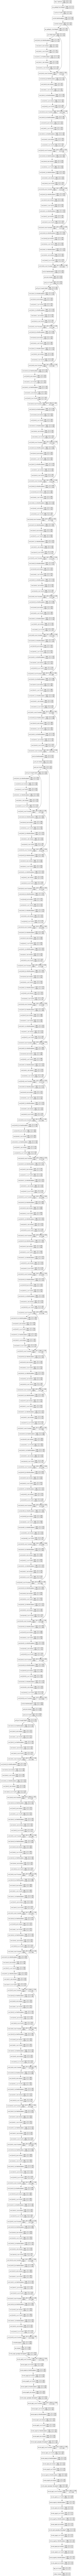

In [17]:
plot_model(model_densenet121,show_shapes=True)

In [18]:
model_densenet121.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [19]:
predict_test_densenet121= np.load('D:/TugasAkhir/DataSet/NPY File/monusac_densenet121_unet_predict_test_ov5_home.npz')['arr_0']

In [20]:
predict_test_densenet121.shape

(584, 256, 256, 5)

Train index = 16


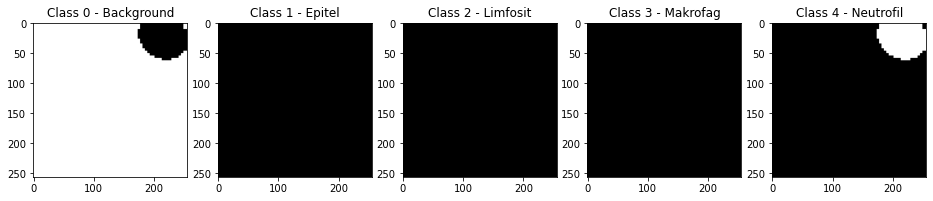

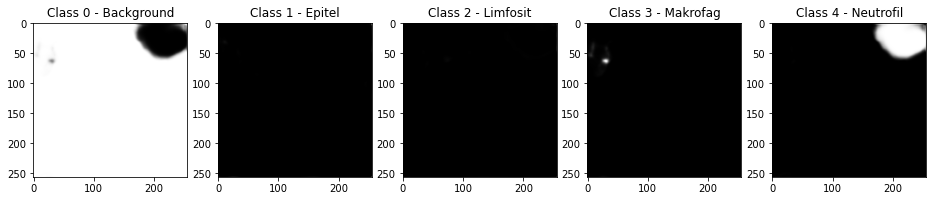

In [21]:
ind_test = random.randint(0, X_test.shape[0]-1)
#ind_test=301
print("Train index =", ind_test)
visualize (y_test[ind_test],predict_test_densenet121[ind_test])

In [22]:
#coba predict citra diatas
predict_test_argmax_densenet121=np.argmax(predict_test_densenet121[ind_test], axis=2)

In [23]:
predict_test_argmax_densenet121.shape

(256, 256)

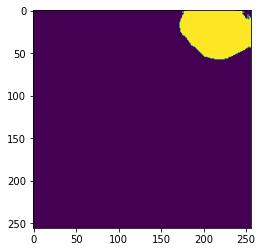

In [24]:
plt.imshow(predict_test_argmax_densenet121, cmap='viridis')

In [25]:
np.unique(predict_test_argmax_densenet121)

array([0, 4], dtype=int64)

## Model densenet121-UNet IoU & PQ Metric

In [26]:
#IoU 
predict_test_argmax_all_densenet121=np.argmax(predict_test_densenet121, axis=3)

In [27]:
predict_test_argmax_all_densenet121.shape

(584, 256, 256)

In [28]:
predict_test_argmax_allchannel_densenet121=to_categorical(predict_test_argmax_all_densenet121, num_classes=5)

In [29]:
predict_test_argmax_allchannel_densenet121.shape

(584, 256, 256, 5)

In [30]:
average_iou_dense,class0_dense,class1_dense,class2_dense,class3_dense,class4_dense=IoU(y_test,predict_test_argmax_allchannel_densenet121)

In [31]:
print("Densenet121-UNet")
print("Average IoU      : ", average_iou_dense)
print("IoU for class0 is: ", class0_dense)
print("IoU for class1 is: ", class1_dense)
print("IoU for class2 is: ", class2_dense)
print("IoU for class3 is: ", class3_dense)
print("IoU for class4 is: ", class4_dense)

Densenet121-UNet
Average IoU      :  0.8311518368612253
IoU for class0 is:  0.9669926497998148
IoU for class1 is:  0.845661323043961
IoU for class2 is:  0.780606054231255
IoU for class3 is:  0.876612973598318
IoU for class4 is:  0.8126498572238867


In [32]:
y_test_all = np.argmax(y_test, axis=3)
print(y_test_all.shape)
print(predict_test_argmax_all_densenet121.shape)

(584, 256, 256)
(584, 256, 256)


In [33]:
pq_metric_model_densenet121=[]
for i in range(len(y_test_all)):   
    pq_metric = Panoptic_quality(y_test_all[i], predict_test_argmax_all_densenet121[i])    
    #print(i,pq_metric)
    pq_metric_model_densenet121.append(pq_metric)
pq_metric_model_densenet121 = np.array(pq_metric_model_densenet121) 
pq_metric_densenet121 = pq_metric_model_densenet121[pq_metric_model_densenet121.nonzero()].mean()   
print("Mean PQ : ", pq_metric_densenet121)

Mean PQ :  0.7900106098560303


# Model efficientnetb3-UNet

In [34]:
model_efficientnetb3= keras.models.load_model("D:/TugasAkhir/DataSet/h5 file/monusac_efficientnetb3_unet_ov5_home.h5")

ValueError: Unknown layer: FixedDropout

In [35]:
predict_test_efficientnetb3= np.load('D:/TugasAkhir/DataSet/NPY File/monusac_efficientnetb3_unet_predict_test_ov5_home.npz')['arr_0']

In [36]:
predict_test_efficientnetb3.shape

(584, 256, 256, 5)

Train index = 16


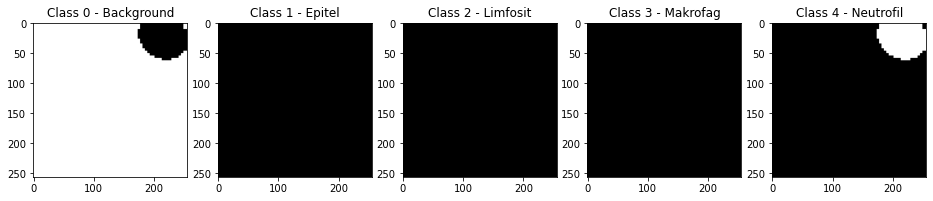

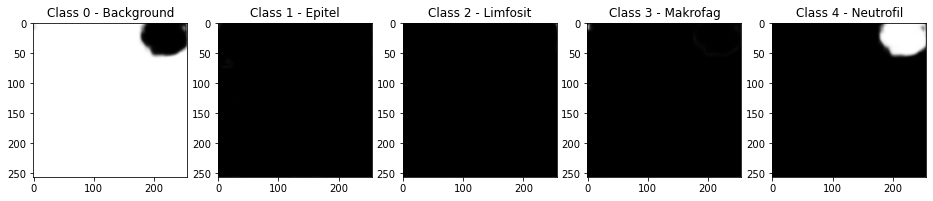

In [37]:
print("Train index =", ind_test)
visualize (y_test[ind_test],predict_test_efficientnetb3[ind_test])

In [38]:
#coba predict citra diatas
predict_test_argmax_efficientnetb3=np.argmax(predict_test_efficientnetb3[ind_test], axis=2)

In [39]:
predict_test_argmax_efficientnetb3.shape

(256, 256)

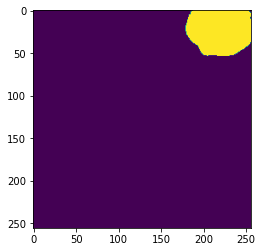

In [40]:
plt.imshow(predict_test_argmax_efficientnetb3, cmap='viridis')

In [41]:
np.unique(predict_test_argmax_efficientnetb3)

array([0, 4], dtype=int64)

## Model efficientnetb3-UNet IoU & PQ Metric

In [42]:
#IoU 
predict_test_argmax_all_efficientnetb3=np.argmax(predict_test_efficientnetb3, axis=3)

In [43]:
predict_test_argmax_all_efficientnetb3.shape

(584, 256, 256)

In [44]:
predict_test_argmax_allchannel_efficientnetb3=to_categorical(predict_test_argmax_all_efficientnetb3, num_classes=5)

In [45]:
predict_test_argmax_allchannel_efficientnetb3.shape

(584, 256, 256, 5)

In [46]:
average_iou_eff,class0_eff,class1_eff,class2_eff,class3_eff,class4_eff=IoU(y_test,predict_test_argmax_allchannel_efficientnetb3)

In [47]:
print("Efficientnetb3-UNet")
print("Average IoU      : ", average_iou_eff)
print("IoU for class0 is: ", class0_eff)
print("IoU for class1 is: ", class1_eff)
print("IoU for class2 is: ", class2_eff)
print("IoU for class3 is: ", class3_eff)
print("IoU for class4 is: ", class4_eff)

Efficientnetb3-UNet
Average IoU      :  0.7945811968157185
IoU for class0 is:  0.9616451103276175
IoU for class1 is:  0.8138666008120414
IoU for class2 is:  0.7392983542293007
IoU for class3 is:  0.7905247246814501
IoU for class4 is:  0.7323758512254486


In [48]:
print(y_test_all.shape)
print(predict_test_argmax_all_efficientnetb3.shape)

(584, 256, 256)
(584, 256, 256)


In [49]:
pq_metric_model_efficientnetb3=[]
for i in range(len(y_test_all)):   
    pq_metric = Panoptic_quality(y_test_all[i], predict_test_argmax_all_efficientnetb3[i])    
    #print(i,pq_metric)
    pq_metric_model_efficientnetb3.append(pq_metric)
pq_metric_model_efficientnetb3 = np.array(pq_metric_model_efficientnetb3) 
pq_metric_efficientnetb3 = pq_metric_model_efficientnetb3[pq_metric_model_efficientnetb3.nonzero()].mean()   
print("Mean PQ : ", pq_metric_efficientnetb3)

Mean PQ :  0.735039560927111


# Model ResNet50-UNet

In [50]:
model_resnet50= keras.models.load_model("D:/TugasAkhir/DataSet/h5 file/monusac_resnet50_unet_ov5_home.h5")

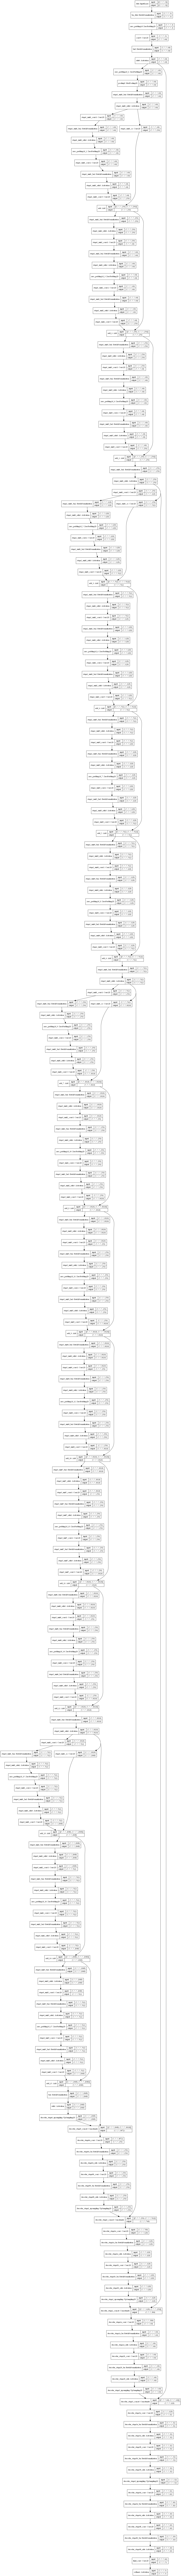

In [51]:
plot_model(model_resnet50,show_shapes=True)

In [52]:
model_resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [53]:
predict_test_resnet50= np.load('D:/TugasAkhir/DataSet/NPY File/monusac_resnet50_unet_predict_test_ov5_home.npz')['arr_0']

In [54]:
predict_test_resnet50.shape

(584, 256, 256, 5)

Train index = 16


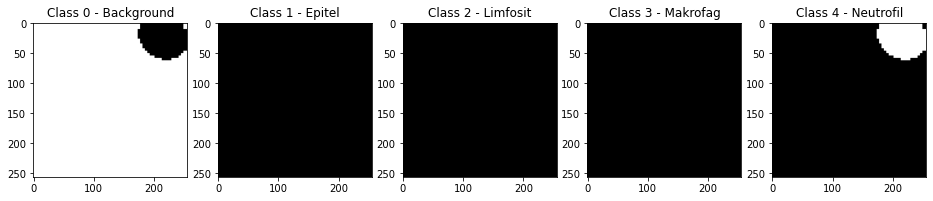

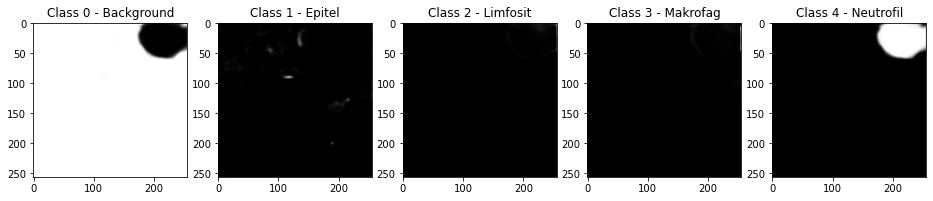

In [55]:
print("Train index =", ind_test)
visualize (y_test[ind_test],predict_test_resnet50[ind_test])

In [56]:
#coba predict citra diatas
predict_test_argmax_resnet50=np.argmax(predict_test_resnet50[ind_test], axis=2)

In [57]:
predict_test_argmax_resnet50.shape

(256, 256)

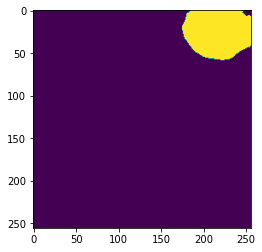

In [58]:
plt.imshow(predict_test_argmax_resnet50, cmap='viridis')

In [59]:
np.unique(predict_test_argmax_resnet50)

array([0, 4], dtype=int64)

## Model ResNet50-UNet IoU & PQ Metric

In [60]:
#IoU 
predict_test_argmax_all_resnet50=np.argmax(predict_test_resnet50, axis=3)

In [61]:
predict_test_argmax_all_resnet50.shape

(584, 256, 256)

In [62]:
predict_test_argmax_allchannel_resnet50=to_categorical(predict_test_argmax_all_resnet50, num_classes=5)

In [63]:
predict_test_argmax_allchannel_resnet50.shape

(584, 256, 256, 5)

In [64]:
average_iou_resnet50,class0_resnet50,class1_resnet50,class2_resnet50,class3_resnet50,class4_resnet50=IoU(y_test,predict_test_argmax_allchannel_resnet50)

In [65]:
print("Resnet50-UNet")
print("Average IoU      : ", average_iou_resnet50)
print("IoU for class0 is: ", class0_resnet50)
print("IoU for class1 is: ", class1_resnet50)
print("IoU for class2 is: ", class2_resnet50)
print("IoU for class3 is: ", class3_resnet50)
print("IoU for class4 is: ", class4_resnet50)

Resnet50-UNet
Average IoU      :  0.8262434434931631
IoU for class0 is:  0.9685791882913706
IoU for class1 is:  0.8491245957745115
IoU for class2 is:  0.7777344173793367
IoU for class3 is:  0.8289701459730863
IoU for class4 is:  0.7660330857343364


In [66]:
print(y_test_all.shape)
print(predict_test_argmax_all_resnet50.shape)

(584, 256, 256)
(584, 256, 256)


In [67]:
pq_metric_model_resnet50=[]
for i in range(len(y_test_all)):   
    pq_metric = Panoptic_quality(y_test_all[i], predict_test_argmax_all_resnet50[i])    
    #print(i,pq_metric)
    pq_metric_model_resnet50.append(pq_metric)
pq_metric_model_resnet50 = np.array(pq_metric_model_resnet50) 
pq_metric_resnet50 = pq_metric_model_resnet50[pq_metric_model_resnet50.nonzero()].mean()   
print("Mean PQ : ", pq_metric_resnet50)

Mean PQ :  0.7825862396132477
